# Mountain Car
- It has two states:
  - car's position $x$
  - car's velocity $\dot{x}$
- It has three actions: 
  - positive: move forward
  - negative: move backward
  - zero: no motion
- It gets a reward of -1 everytime it fails to reach its goal (flag position)
- Each episode consists of 200 steps and leading to a total reward of -200 in the beginning. 
- The aim is to learn to achieve the goal in less than 200 steps. Lesser the number of steps taken, better is the algorithm. 

- We demonstrate working of following concepts
  - DQN with experience replay
  - Double DQN with Polyak Averaging

## Understanding MountainCar Problem

In [0]:
import gym
env = gym.make('MountainCar-v0')

print('state_space_size: {}'.format(env.observation_space.shape))
print('action_space_size: {}'.format(env.action_space.n))

for e in range(5): 
  obs = env.reset()
  done = False
  score = 0
  t = 0
  while not done:
    env.render()
    action = env.action_space.sample()
    next_obs, reward, done, _ = env.step(action)
    score += reward
    t += 1
    obs = next_obs

    if done:
      print('Episode: {}, Length: {}, score: {}'.format(e, t, score))
      break
env.close()


state_space_size: (2,)
action_space_size: 3


NameError: ignored

## Double DQN
- With and without Polyak Averaging

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import gym
import random
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.optimizers import Adam
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
import pickle

# disable deprecated warnings
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

# Check the GPU availability

print('TensorFlow Version: {}'.format(tf.__version__))

if tf.__version__ < "2.0":
  get_available_gpus()
else:
  device_name = tf.test.gpu_device_name()
  print(device_name)
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))



class DQNAgent:
  def __init__(self, state_size, action_size,
               memorySize = 20000,
               discountFactor = 0.95,
               learningRate = 0.001,
               trainStart = 1000,
               epsilon = 1.0, # change this if you are loading saved weights
               epsilon_decay_rate = 0.99,
               ddqn_flag = True,
               load_weights_path = None,
               load_exp_path = None):
    
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=memorySize)
    self.trainStart = trainStart
    self.learningRate = learningRate
    self.discountFactor = discountFactor
    self.epsilon = epsilon
    self.epsilon_decay_rate = epsilon_decay_rate
    self.ddqn = ddqn_flag

    self.model = self._build_model()
    self.target_model = self._build_model()

    if load_weights_path is not None:
      self.model.load_weights(load_weights_path)
      print('Weights loaded from File')

    if load_exp_path is not None:
      with open(load_exp_path, 'rb') as file:
        self.memory = pickle.load(file)
      print('Experience loaded from file')
      
    # initially both models share same weight
    self.target_model.set_weights(self.model.get_weights())

  
  def _build_model(self):
    model = Sequential()
    model.add(Dense(30, input_dim=self.state_size, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.summary()
    model.compile(loss='mse', optimizer=Adam(lr=self.learningRate))
    return model

  def update_target_network(self):
    ''' Simply copy the weights from original model'''
    self.target_model.set_weights(self.model.get_weights())

  def update_target_network2(self, tau=0.1):
    ''' Implements Polyak Averaging for weight update 
        in target network
    '''
    if self.ddqn:
      weights = self.model.get_weights()
      target_weights = self.target_model.get_weights()
      for i in range(len(target_weights)):
        target_weights[i] = weights[i] * tau + target_weights[i] * (1-tau)
      self.target_model.set_weights(target_weights)
    else:
      self.target_model.set_weights(self.model.get_weights())

  def update_epsilon(self):
    '''
    Reduce exploration rate over time
    '''
    if self.epsilon > 0.01:
      self.epsilon *= self.epsilon_decay_rate
    else:
      self.epsilon = 0.01

  def add_experience(self, state, action, reward, next_state, done):
    '''  Add experiences to the replay memory '''
    self.memory.append([state, action, reward, next_state, done])

  def select_action(self, state):
    '''Implements epsilon-greedy policy '''
    if (random.random() < self.epsilon):
      action = np.random.randint(0, self.action_size)
    else: 
      q_values = self.model.predict(state)
      action = np.argmax(q_values[0])
    return action

  def get_maxQvalue_nextstate(self, next_state):
    # max Q value among the next state's action
    if self.ddqn:
      # DDQN
      # Current Q network selects the action
      # a'_max = argmax_a' Q(s',a')
      action = np.argmax(self.model.predict(next_state)[0])
      # target Q network evaluates the action
      # Q_max = Q_target(s', a'_max)
      max_q_value = self.target_model.predict(next_state)[0][action]
    else: 
      # DQN chooses the max Q value among next actions
      # Selection and evaluation of action is on the target Q network
      # Q_max = max_a' Q_target(s', a')
      max_q_value = np.amax(self.target_model.predict(next_state)[0])

    return max_q_value

  def train_model(self, batch_size):
    ''' Training on Mini-Batch with Experience Replay  '''

    if len(self.memory) < batch_size:
      return

    mini_batch = random.sample(self.memory, batch_size)
    current_state = np.zeros((batch_size, self.state_size))
    next_state = np.zeros((batch_size, self.state_size))
    qValues = np.zeros((batch_size, self.action_size))
  
    #action, reward, done = [], [], []
    action = np.zeros(batch_size, dtype=int)
    reward = np.zeros(batch_size)
    done = np.zeros(batch_size, dtype=bool)

    for i in range(batch_size):
      current_state[i] = mini_batch[i][0]   # current_state
      action[i] = mini_batch[i][1]
      reward[i] = mini_batch[i][2]
      next_state[i] = mini_batch[i][3]  # next_state
      done[i] = mini_batch[i][4]

      qValues[i] = self.model.predict(\
          current_state[i].reshape(1,self.state_size))[0]
      max_qvalue_ns = self.get_maxQvalue_nextstate(\
                next_state[i].reshape(1,self.state_size))

      if done[i]:
        qValues[i][action[i]] = reward[i]
      else:
        qValues[i][action[i]] = reward[i] + \
                    self.discountFactor * max_qvalue_ns

    # train the model
    self.model.fit(current_state, qValues, 
                   batch_size = batch_size,
                   epochs=1, verbose=0)
    
    # update epsilon with each training step
    self.update_epsilon()

############

if __name__ == "__main__":

  env = gym.make('MountainCar-v0')

  maxEpochs = 2000 # people are running for 3000 episodes
  maxSteps = 201 
  targetNetworkUpdateFreq = 10 # make it 10
  batch_size = 64
  train_start = 1000
  model_save_freq = 100
  

  last100Scores=deque(maxlen=100)
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n


  # Create a DQN Agent
  deepQ = DQNAgent(state_size, action_size,
                   trainStart = train_start)

  min_steps = 199
  stepCounter = 0
  Scores = []
  AvgScores = []
  carPositions = []
  Avg100Scores = []
  epoch = 0
  while epoch < maxEpochs:

    state = env.reset().reshape(1,state_size)
  
    score = 0
    for t in range(maxSteps):
      #env.render()
      
      action = deepQ.select_action(state)
      next_state, reward, done, info = env.step(action)
      next_state = np.reshape(next_state, [1, state_size])
      #reward = reward if not done else -20 # not tested yt

      if next_state[0][0] >= 0.5:
        reward += 20

      # number of steps taken is our score
      score += 1
      
      # add experiences to replay memory
      deepQ.add_experience(state, action, reward, \
                           next_state, done)

      # experience replay - training
      if stepCounter > train_start: 
        deepQ.train_model(batch_size)

        if stepCounter % targetNetworkUpdateFreq == 0:
          deepQ.update_target_network()

      stepCounter += 1
      state = next_state
      

      if done:
        Scores.append(score)
        AvgScores.append(np.mean(Scores))
        last100Scores.append(score)
        Avg100Scores.append(np.mean(last100Scores))

        print('Episode: {}, time steps: {}, score: {}, AvgScore: {:0.2f}, \
        epsilon: {:0.2f}, replay size: {}, Step Count: {}'.format(epoch, t, score, \
                                                  np.mean(Scores), 
                                                  deepQ.epsilon,
                                                  len(deepQ.memory),
                                                  stepCounter))
        # store into file
        with open('/content/gdrive/My Drive/Colab_Models/result.txt','a+') as file2:
          file2.write('{}\t {} \t {} \t {:0.2f} \t {:0.2f}\t {}\n'\
                         .format(epoch, t, score, np.mean(Scores),\
                                  deepQ.epsilon, stepCounter))
        #print('wrote into file')
        break
    
    # time-step for-loop ends here
    # save best models 
    if t < min_steps:
      min_steps = t
      deepQ.model.save_weights('/content/gdrive/My Drive/Colab_Models/model_steps_{}.h5'.format(t))
 
    # record car position at the end of each episode
    carPositions.append(state[0][0])

    # update epoch count
    epoch += 1

    # save model weights
    if epoch % model_save_freq == 0:
      deepQ.model.save_weights('/content/gdrive/My Drive/Colab_Models/model_{}.h5'.format(epoch))
      #deepQ.model.save_weights('model_{}.h5'.format(epoch+1))
      #print('Model Saved')

      with open("/content/gdrive/My Drive/Colab_Models/exp_{}.txt"\
                .format(epoch), 'wb') as file:
            pickle.dump(deepQ.memory, file)
  # episode loop ends here
    
  # plot
  fig,axes = plt.subplots(2,sharex=True)
  axes[0].plot(Scores)
  axes[0].plot(AvgScores)
  axes[0].set(xlabel='Episodes', ylabel='Scores')
  axes[0].legend(['Actual', 'Average'])
  axes[1].plot(carPositions)
  axes[1].set(ylabel='Car Positions')
    

  

Using TensorFlow backend.


TensorFlow Version: 1.15.0



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                90        
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 183       
Total params: 2,133
Trainable params: 2,133
Non-trainable params: 0
_________________________________________________________________

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                90        
_________________________________________________________________
dense_5 (Dense)              (None, 60)                1860      

In [0]:
%debug

In [0]:
env = gym.make('MountainCar-v0')

maxSteps = 200
# Create a DQN Agent
deepQ = DQNAgent(state_size, action_size,
                 epsilon = 0.01,
                 ddqn_flag = True,
                 load_weights_path='/content/gdrive/My Drive/Colab_Models/model_100.h5',
                 load_exp_path='/content/gdrive/My Drive/Colab_Models/exp_100.txt')


state = env.reset().reshape(1,state_size)

score = 0
for t in range(maxSteps):
  env.render()
  action = deepQ.select_action(state)
  next_state, reward, done, info = env.step(action)
  next_state = np.reshape(next_state, [1, state_size])
  
  # number of steps taken is our score
  score += reward
  state = next_state
      

  if done:
    print('Score: {}'.format(score)
    break;
env.close()


[Text(0, 0.5, 'Car Positions')]

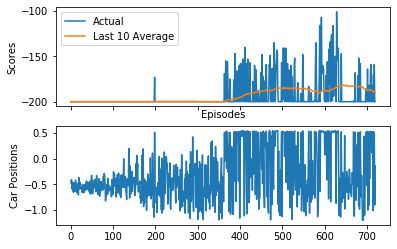

In [0]:
 # plot
fig,axes = plt.subplots(2,1,sharex=True)
axes[0].plot(Scores)
axes[0].plot(Avg100Scores)
axes[0].set(xlabel='Episodes', ylabel='Scores')
axes[0].legend(['Actual', 'Last 100 Average'])
axes[1].plot(carPositions)
axes[1].set(ylabel='Car Positions')



In [0]:
!mkdir /content/gdrive/My\ Drive/Colab_Models

In [0]:
!ls /content/gdrive/My\ Drive

Colab_Models		 Review1507.txt.gdoc
Edge-Hill		 Review1509.txt.gdoc
EPSRC-Project-i2WB.gdoc  Ro-MAN2019-TransLearn-WS-Paper-Upload
Oxford_Data
